#PRACTICAL SESSION 3

STEP 1: Importing the libraries

In [1]:
# Important lybraries
import csv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm 
import math

STEP 2: Defining a class to create usable data

In [76]:
class Data:
  def __init__(self,fileName):
    self.loadData(fileName)
    self.splitData(0)

  def loadData(self,fileName):
    # Uses a csv file to create a numpy array
    with open(fileName, newline='') as csvfile:
      reader = csv.reader(csvfile, delimiter=',', quotechar='|')
      data = list(reader)
    data = np.array(data)
    self.X = np.array(data[1:np.shape(data)[0],0:-1],dtype='float64')  
    ydata = np.array(data[1:np.shape(data)[0],-1],dtype='int32')
    self.y = np.zeros((len(ydata),np.amax(ydata)-np.amin(ydata)+1))
    for i in range(self.y.shape[0]):
      for j in range(self.y.shape[1]):
        if ydata[i] == j+1:
            self.y[i,j] = 1

  def splitData(self,testRatio):
    # Shuffles the data and splits data in train and test 
    M      = self.X.shape[0]
    ntrain = int((1-testRatio)*M) 
    idx    = np.arange(M)
    np.random.shuffle(idx) 
    self.Xtrain = self.X[idx[0:ntrain],:]
    self.Xtest  = self.X[idx[ntrain:M],:]
    self.Ytrain = self.y[idx[0:ntrain],:]
    self.Ytest  = self.y[idx[ntrain:M],:]

  def plotCorrelationMatrix(self):
    # Plots the variables two by two
    nF = self.X.shape[1]
    figure, axes = plt.subplots(nrows=nF, ncols=nF)
    plt.gcf().set_size_inches(10, 8)
    color = self.y@np.arange(1, self.y.shape[1]+1, 1, dtype=int).T
    self.color = color
    for i in range(nF):
      for j in range(nF):
        if i == j:
          axes[i,j].hist(self.X[:,j])
        else:
          axes[i,j].scatter(self.X[:,j],self.X[:,i],c=self.color,cmap=cm.brg)
    plt.show()  

  def plotData(self,i,j):
    # It plots Xi vs Xj
    plt.scatter(self.X[:,i],self.X[:,j],c=self.color,cmap=cm.brg)
  
  def scale(self):
    # Scales the data to a (0,1) interval
    for i in range(self.X.shape[1]):
      self.X[:,i] = (self.X[:,i] - np.amin(self.X[:,i]))/(np.amax(self.X[:,i])-np.amin(self.X[:,i]))

def buildmodel(Xtr,Ytr,d,idx,hlay):
  comb = int(math.factorial(d+2)/(math.factorial(d)*math.factorial(2)))
  X    = np.ones((Xtr.shape[0],comb))
  cont = 1
  for i in range(1,d+1):
    for j in range(0,i+1):
      X[:,cont]  = Xtr[:,idx[0]]**(i-j)*Xtr[:,idx[1]]**(j)
      cont += 1
  Y = Ytr
  topology = hlay.copy()
  topology.insert(0,X.shape[1])
  topology.append(Ytr.shape[1])
  w = []
  for i in range(len(topology)-1):
    u = (6/(topology[i]+topology[i+1]))**0.5
    w.append(np.random.uniform(-u,u,(topology[i]*topology[i+1],1)))
  theta = np.concatenate(w,axis=0)
  return theta,X,Y,topology

def PlotBoundary(data,theta,d,idx,topology):
    X = data.X[:,idx]
    Y = data.y
    n_points = 200
    x1 = np.linspace(np.min(X[:,0]),np.max(X[:,0]),n_points)[:,np.newaxis]
    x2 = np.linspace(np.min(X[:,1]),np.max(X[:,1]),n_points)[:,np.newaxis]
    xtest = np.zeros((n_points,topology[0],n_points))
    h = np.zeros((n_points*topology[-1],n_points))
    for i in range(n_points):
        x2_aux = np.ones((n_points,1))*x2[i,0]
        xdata_test = np.concatenate((x1,x2_aux),axis=1)
        _,xtest[:,:,i],_,_ = buildmodel(xdata_test,Y,d,[0,1],topology[1:-1]) 
        haux = predict(theta,topology,xtest[:,:,i],l)
        h[:,i] = np.reshape(haux.T,(n_points*Y.shape[1],))
    data.plotData(idx[0],idx[1])
    x1_draw = np.reshape(x1,(n_points,))
    x2_draw = np.reshape(x2,(n_points,))
    x1_draw,x2_draw = np.meshgrid(x1_draw,x2_draw)
    cl = ['blue','red','green']
    for j in range(topology[-1]):
        h_draw = h[(j*n_points):((j+1)*n_points),:].T   
        plt.contour(x1_draw,x2_draw,h_draw,levels = [0.5],colors = cl[j])

def testAccuracy(X,Y,theta,topology,l):
  g = predict(theta,topology,X,l)
  cont = 0
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if g[i,j] == np.amax(g[i,:]):
        p = j
      if Y[i,j] == np.amax(Y[i,:]):
        t = j
    if p == t:
      cont += 1 
  TA = cont/Y.shape[0]
  return TA

In [85]:
class SGD:
  def __init__(self,lr,epochs,batch,plot):
    self.lr = lr
    self.maxepochs = epochs
    self.batchSz =batch
    self.plot = plot
    self.optHIST = []

  def train(self,F,f,X,Y,theta):
    # Here occurs the main loop of the minimization
    epoch = 0
    iter  = 0
    nB    = X.shape[0]//self.batchSz
    while epoch < self.maxepochs:
      if (nB == 1 or nB == 0):
        order = np.arange(X.shape[0])
        nB = 1;
      else:
        order = np.random.permutation(X.shape[0])
      for i in range(nB):
        Xb,Yb = self.createMinibatch(X,Y,order,i)
        Ja    = F(theta,Xb,Yb)
        grad  = f(theta,Ja[1],Yb)
        gnorm = np.linalg.norm(grad)
        theta  = self.step(theta,grad)
        self.optHIST.append([Ja[0],gnorm])
        iter = iter + 1
      epoch  += 1
    self.optHIST = np.array(self.optHIST)
    self.plotEnd(nB)
    return theta
  
  def step(self,theta,grad):
    # Update the parameters
    theta = theta - self.lr*grad
    return theta

  def createMinibatch(self,X,Y,order,i):
    # Function that creates the minibatch
    cont = 0
    bs = self.batchSz
    if (i == X.shape[0]//bs-1):
      plus = X.shape[0]%bs
    else:
      plus = 0
    Xb = X[order[i*bs:(i+1)*bs+plus],:]
    Yb = Y[order[i*bs:(i+1)*bs+plus],:]
    return Xb,Yb

  def printStatus(self,epoch,iter,J,gnorm,theta,outFCN,X,Y):
    # Function that prints every x iterations the Loss and the gradient norm
    if (epoch == 0 and iter == 0):
      print('Epoch','Iter','Loss          ','GNorm')
    if ((epoch+1) %(self.maxepochs//10) == 0):
      print(epoch+1,iter+1,J,gnorm)
    if (epoch+1) %(self.maxepochs//5) == 0 and self.plot==True and 1==0:
      plt.title('Boundary')
      outFCN(theta)
      
  def plotEnd(self,nB):
    # A function that plots at the end the evolution of the function value and the step size
    if (self.plot == True):
      plt.show()
      plt.figure(1,figsize=(10,5))
      s = np.arange(0,self.maxepochs,100)
      plt.subplot(1,2,1)
      plt.title('Function value vs iter')
      plt.scatter(s,self.optHIST[s,0])
      plt.subplot(1,2,2)
      plt.title('Step size vs iter')
      plt.scatter(s,self.optHIST[s,1])
      plt.show()

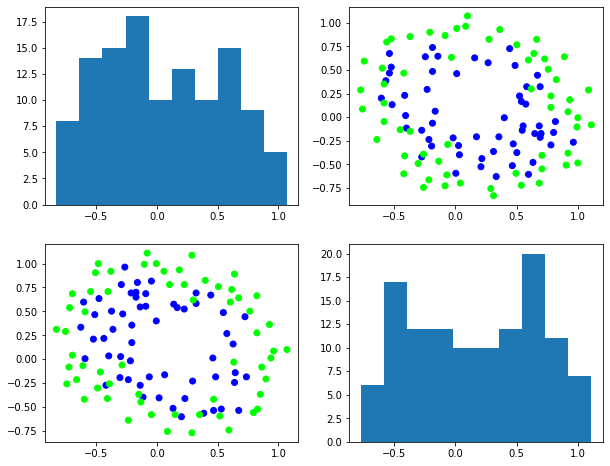

In [52]:
data = Data('P3_nn_microchip.csv')
data.splitData(0.2)
data.plotCorrelationMatrix()

STEP 3: Computing the derivatives

In [9]:
def hypothesisFunction(X,theta):
  h = X@theta
  return h

def actFCN(z):
  g = 1/(1+math.e**(-z))
  g_der = z*(1-z)
  return g,g_der

def crossentroy(P,T):
  logP0 = np.where(P > 10**(-16), P, -16)
  logP1 = np.where(1-P > 10**(-16), 1-P, -16)
  L     = -np.mean(np.sum(T*np.log(logP0,out=logP0,where=logP0>0)+(1-T)*np.log(logP1,out=logP1,where=logP1>0),axis=1))
  L_der = (P-T)/(P*(1-P))
  return L,L_der

def regularization(l,theta):
  r  = l*0.5*np.sum(theta**2)
  r_der = l*theta
  return r,r_der

STEP 4: Forward and backward propagation

In [79]:
# Define a function that performs the forward propagation and returns the cost and the stored values of the activation functions
def forwardprop(theta,topology,X,Y,l):
  a = [X]
  cont = 0
  for k in range(len(topology)-1):
    theta_l = np.reshape(theta[cont:cont+topology[k]*topology[k+1]],(topology[k],topology[k+1]))
    cont = cont + topology[k]*topology[k+1]
    h = hypothesisFunction(a[k],theta_l)
    aux,_ = actFCN(h)
    a.append(aux)
  R,_ = regularization(l,theta)
  L,_ = crossentroy(a[-1],Y)
  J = L + R
  return J,a

In [80]:
# Define a function that performs the backward propagation and returns the gradient of the model
def backprop(theta,topology,a,Y,l):
  delta = []
  m    = Y.shape[0]
  cont = len(theta)
  grad = np.zeros((theta.shape[0],1))
  for k in range(len(topology)-1,0,-1):
    _,act_der = actFCN(a[k])
    if k == len(topology)-1:
      _,L_der = crossentroy(a[-1],Y)
      delta.insert(0,L_der*act_der)
    else:
      theta_l = np.reshape(theta[cont:cont+topology[k]*topology[k+1]],(topology[k],topology[k+1]))
      delta.insert(0,delta[0]@theta_l.T*act_der)
    grad[cont-topology[k-1]*topology[k]:cont] = 1/m*np.reshape((a[k-1].T@delta[0]),(topology[k-1]*topology[k],1))
    cont = cont-topology[k-1]*topology[k]
  _,r_der = regularization(l,theta)
  grad = grad + r_der
  return grad

In [81]:
# Define a function predict really similar to forwardprop but which just returns the activation in the last layer (output)
def predict(theta,topology,X,l):
  a = [X]
  cont = 0
  for k in range(len(topology)-1):
    theta_l = np.reshape(theta[cont:cont+topology[k]*topology[k+1]],(topology[k],topology[k+1]))
    cont = cont + topology[k]*topology[k+1]
    h = hypothesisFunction(a[k],theta_l)
    aux,_ = actFCN(h)
    a.append(aux)
  return a[-1]

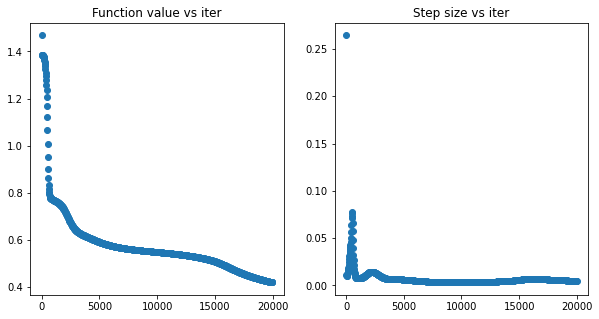


Train accuracy:  0.9139784946236559 
Test accuracy:  0.7083333333333334


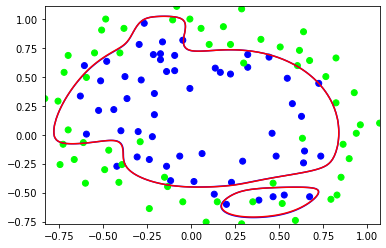

In [67]:
d = 2
l = 0.0
idx = [0,1]
hiddenlayers = [4,8]
lr = 0.5
theta0,Xtr,Ytr,topology = buildmodel(data.Xtrain,data.Ytrain,d,idx,hiddenlayers)
_,Xte,Yte,_ = buildmodel(data.Xtest,data.Ytest,d,idx,hiddenlayers)

F = lambda theta,X,Y: forwardprop(theta,topology,X,Y,l)
f = lambda theta,a,Y: backprop(theta,topology,a,Y,l)
gd = SGD(lr=lr,epochs=20000,batch=Xtr.shape[0],plot=True)
thetaOPT = gd.train(F,f,Xtr,Ytr,theta0)
PlotBoundary(data,thetaOPT,d,idx,topology)

tr = testAccuracy(Xtr,Ytr,thetaOPT,topology,l)
te = testAccuracy(Xte,Yte,thetaOPT,topology,l)
print('\nTrain accuracy: ',tr,'\nTest accuracy: ',te)
plt.show()

STEP 5: Multiclassification

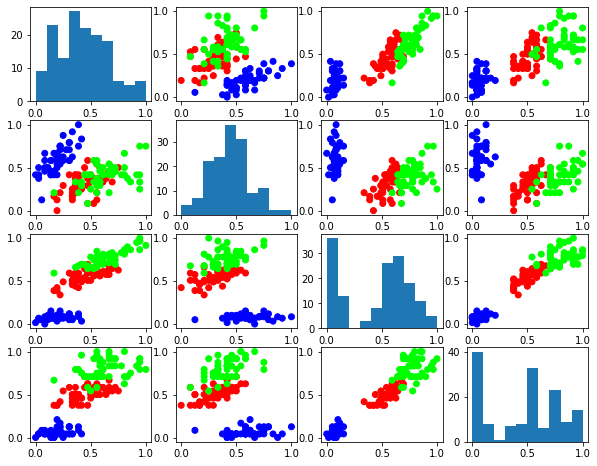

In [68]:
iris = Data('P3_nn_iris.csv')
iris.scale()
iris.splitData(0.2)
iris.plotCorrelationMatrix()

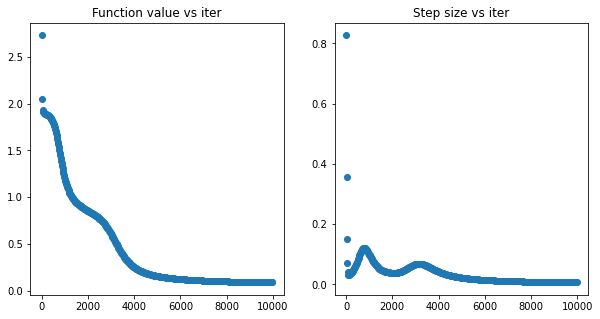


Train accuracy:  0.9831932773109243 
Test accuracy:  0.9


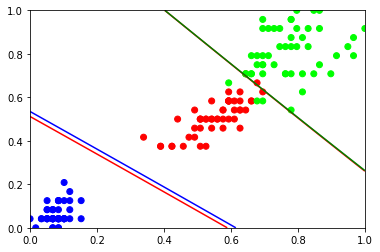

In [78]:
d = 1
l = 0.0
idx = [2,3]
hiddenlayers = [4,8]
lr = 0.1
theta0,Xtr,Ytr,topology = buildmodel(iris.Xtrain,iris.Ytrain,d,idx,hiddenlayers)
_,Xte,Yte,_ = buildmodel(iris.Xtest,iris.Ytest,d,idx,hiddenlayers)

F = lambda theta,X,Y: forwardprop(theta,topology,X,Y,l)
f = lambda theta,a,Y: backprop(theta,topology,a,Y,l)
gd = SGD(lr=lr,epochs=10000,batch=Xtr.shape[0],plot=True)
thetaOPT = gd.train(F,f,Xtr,Ytr,theta0)
PlotBoundary(iris,thetaOPT,d,idx,topology)

tr = testAccuracy(Xtr,Ytr,thetaOPT,topology,l)
te = testAccuracy(Xte,Yte,thetaOPT,topology,l)
print('\nTrain accuracy: ',tr,'\nTest accuracy: ',te)
plt.show()

STEP 6: Batch Size

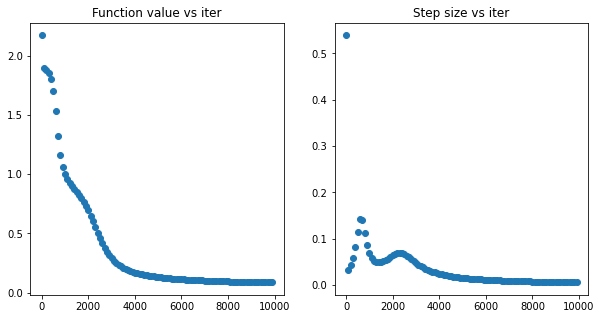


Train accuracy:  0.9831932773109243 
Test accuracy:  0.9


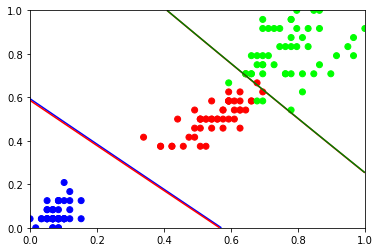

In [89]:
d = 1
l = 0.0
idx = [2,3]
hiddenlayers = [4,8]
m = Xtr.shape[0]
lr = 0.1
theta0,Xtr,Ytr,topology = buildmodel(iris.Xtrain,iris.Ytrain,d,idx,hiddenlayers)
_,Xte,Yte,_ = buildmodel(iris.Xtest,iris.Ytest,d,idx,hiddenlayers)

F = lambda theta,X,Y: forwardprop(theta,topology,X,Y,l)
f = lambda theta,a,Y: backprop(theta,topology,a,Y,l)
gd = SGD(lr=lr,epochs=10000,batch=m//1,plot=True)
thetaOPT = gd.train(F,f,Xtr,Ytr,theta0)
PlotBoundary(iris,thetaOPT,d,idx,topology)

tr = testAccuracy(Xtr,Ytr,thetaOPT,topology,l)
te = testAccuracy(Xte,Yte,thetaOPT,topology,l)
print('\nTrain accuracy: ',tr,'\nTest accuracy: ',te)
plt.show()